SHAP visualization
Imports

In [153]:
%pip install loaders
%pip install shap
%pip install tensorflow
%pip install tensorflow-datasets
%pip install pickle

import pickle
import os
import shap
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import jax
from flax.linen import relu
from flax.linen.initializers import kaiming_uniform

from skimage.segmentation import mark_boundaries, slic

from data_loaders import load_cifar10, load_wine_quality
from models import Cifar10CNN, WineQualityNetwork, create_model, load_weights
from utils import prediction, get_grad_cam


os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.


Defaulting to user installation because normal site-packages is not writeable
^C
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation

In [154]:
# Model setup
datapath = './model_checkpoints'

# Random number generator key (seed)
rng = jax.random.PRNGKey(0)

# Download datasets and store the splits
cif_train, cif_val, cif_test = load_cifar10(datapath)
wine_train, wine_val, wine_test = load_wine_quality(datapath)

# Load models
cifar_model, _ = create_model(Cifar10CNN, rng, init_func=kaiming_uniform(), activation_func=relu)
wine_model, _ = create_model(WineQualityNetwork, rng, input_shape=(1, 11), init_func=kaiming_uniform(), activation_func=relu)

# Create weight dictionary
weights = {
    'cifar': {
        0: load_weights(f'./model_checkpoints/cifar10/kaiming_uniform/relu/initial_weights.pkl'),
        1: load_weights(f'./model_checkpoints/cifar10/kaiming_uniform/relu/best_weights.pkl'),
        2: load_weights(f'./model_checkpoints/cifar10/kaiming_uniform/relu/overtrained_model.pkl')
    },
    'wine': {
        0: load_weights(f'./model_checkpoints/wine_quality/kaiming_uniform/relu/initial_weights.pkl'),
        1: load_weights(f'./model_checkpoints/wine_quality/kaiming_uniform/relu/best_weights.pkl'),
        2: load_weights(f'./model_checkpoints/wine_quality/kaiming_uniform/relu/overtrained_model.pkl')
    }
}


2024-05-24 02:11:15.877054: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2024-05-24 02:11:15.902296: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2024-05-24 02:11:32.717443: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-05-24 02:11:33.386532: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Shape of wine_data: (736, 11)
Shape of wine_labels: (736, 1)


100%|██████████| 1/1 [00:01<00:00,  1.39s/it]


Type of SHAP values: <class 'list'>
Length of SHAP values list: 1
Shape of first element in SHAP values: (1, 11)


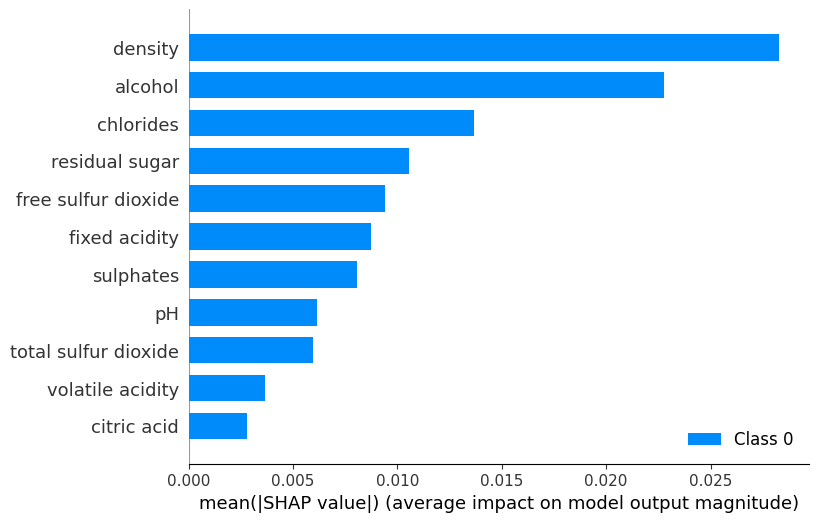

In [156]:
# Unbatch the wine test dataset
unbatched_wine = wine_test.unbatch()

# Convert to numpy arrays
wine_data = np.array([sample[0].numpy() for sample in unbatched_wine])
wine_labels = np.array([sample[1].numpy() for sample in unbatched_wine])

# Debug: Print the shape of wine_data
print(f"Shape of wine_data: {wine_data.shape}")
print(f"Shape of wine_labels: {wine_labels.shape}")

# Create a SHAP Kernel Explainer
explainer = shap.KernelExplainer(lambda data: prediction(weights['wine'][1], wine_model, data), wine_data)

# Get SHAP values for a specific sample
shap_values = explainer.shap_values(wine_data[42:43], nsamples=100)

# Debug: Print the shape of SHAP values
print(f"Type of SHAP values: {type(shap_values)}")
print(f"Length of SHAP values list: {len(shap_values)}")
print(f"Shape of first element in SHAP values: {shap_values[0].shape}")

# Plot the SHAP summary plot
shap.summary_plot(shap_values, wine_data[42:43], feature_names=[
    'fixed acidity', 'volatile acidity', 'citric acid',
    'residual sugar', 'chlorides', 'free sulfur dioxide',
    'total sulfur dioxide', 'density', 'pH', 'sulphates',
    'alcohol'])


In [ ]:
# Unbatch the CIFAR-10 test dataset
unbatched_cifar = cif_test.unbatch()

# Convert to numpy arrays
cifar_data = np.array([sample[0].numpy() for sample in unbatched_cifar])
cifar_labels = np.array([sample[1].numpy() for sample in unbatched_cifar])

# Function to explain an image using SHAP
def explain_image_shap(model, weights, image):
    # Define a SHAP kernel explainer
    explainer = shap.KernelExplainer(lambda data: prediction(weights, model, data), shap.sample(image, 100))

    # Get SHAP values for the image
    shap_values = explainer.shap_values(image)

    return shap_values

# Segment the image using SLIC
def segmentation_fn(image):
    return slic(image, n_segments=15)

# Explanation function for a single image
def explain_single_image_shap(model, weights, image):
    # Explain the image using SHAP
    shap_values = explain_image_shap(model, weights, image)

    # Plot the SHAP summary plot
    shap.summary_plot(shap_values, image, feature_names=['R', 'G', 'B'])

# Explanation function for multiple images
def explain_multiple_images_shap(model, weights, images):
    for i, image in enumerate(images):
        print(f"Explaining image {i + 1}...")
        explain_single_image_shap(model, weights, image)

# Call the explanation function
explain_multiple_images_shap(cifar_model, weights['cifar'][1], cifar_data)